# Stock Uptrend Screening Criteria 📈

## US Market Conditions

To identify uptrending stocks in the US market, the following **Technical Analysis** and **Fundamental Analysis** filters are applied:

###  Screening Conditions 🔍

| **Condition**                                                               | **Explanation**             |
|-----------------------------------------------------------------------------|-----------------------------|
| **EPS > 0**                                                                 | Profitable companies are prioritized. |
| **EMA20 > EMA100**                                                           | Confirms that the short-term trend is stronger than the long-term. |
| **EMA50 > EMA100**                                                           | The medium-term trend supports the overall uptrend. |
| **EMA100 > EMA150**                                                          | Long-term trend indicates continued strength. |
| **EMA20 > EMA50** on **at least 1 day within the last 20 candles**           | Ensuring periodic short-term strength. |
| **Close > 1.05 × EMA150** on **at least 1 day within the last 20 candles**  | The stock price exceeds the long-term moving average, indicating bullish momentum. |
| **Average Daily Volume** over the last 20 candles > **10M**                  | Ensuring that liquidity is sufficient, indicating strong market interest. |
| **Peak Daily Volume** over the last 50 candles > **100M**                   | Volume spikes confirm investor interest and significant market moves. |

---

### Trend Classification 📊 

| **Condition**                                                               | **Trend Category**           |
|-----------------------------------------------------------------------------|------------------------------|
| `C > EMA10`, `C > EMA20`, `C > EMA50`, `C > EMA100`, `C > EMA150`           | **Strong Bullish Trend**     |
| `C > EMA20`, `C > EMA50`, `C > EMA100`, `C > EMA150`                        | **Bullish Trend**            |
| `C > EMA50`, `C > EMA100`, `C > EMA150`                                     | **Up Trend**                 |
| `C > 0.85 × EMA50`, `C > EMA100`, `C > EMA150`                              | **Consolidated Uptrend**     |

---

###  Data Source & Update Mechanism 📌

The stock ticker data is sourced directly from **Google Sheets**, allowing for seamless integration with the screening system.

Whenever updates are made to the sheet, the system **automatically synchronizes** the changes — ensuring that all screening criteria are applied to the most recent data.


<br>

## Import Libary

In [1]:
import time
import numpy as np
import pandas as pd

import yfinance as yf
import pandas_ta as ta

#import plotly.graph_objects as go
import matplotlib.pyplot as plt

import gspread
from oauth2client.service_account import ServiceAccountCredentials

import warnings
warnings.filterwarnings('ignore')

<br>

### Necessary Function 

##### Visualizasion with Plotly ( Optional )

In [21]:
def plot_geometric_returns(df_compound_return,title=''):
    """
    Visualizes compound geometric returns for multiple assets using Plotly.

    Parameters:
    df_compound_return (pd.DataFrame): Time-indexed DataFrame where each column
    represents the geometric return series of an asset.
    """

    fig = go.Figure()

    # Plot each asset's return line
    for col in df_compound_return.columns:
        fig.add_trace(go.Scatter(
            x=df_compound_return.index,
            y=df_compound_return[col],
            mode='lines',
            name=col
        ))

    # Add a horizontal reference line at y=0
    fig.add_shape(
        type='line',
        x0=df_compound_return.index[0],
        x1=df_compound_return.index[-1],
        y0=0,
        y1=0,
        line=dict(color='black', width=4)
    )

    # Set layout parameters for title, axis labels, size, and legend
    fig.update_layout(
        title=title,
        xaxis_title='Date',
        yaxis_title='Compound Return',
        width=1200,
        height=600,
        legend=dict(title='Stocks')
    )

    # Render the interactive plot
    fig.show()

<br>

### Fetch Data

##### From Google Sheet 

In [2]:
scope = [
    "https://spreadsheets.google.com/feeds",
    "https://www.googleapis.com/auth/drive"
]

creds = ServiceAccountCredentials.from_json_keyfile_name(
    "C:/Users/armys/Downloads/gen-lang-client-0544819307-3ccec4ef6e99.json",
    scope
)

client = gspread.authorize(creds)
sheet = client.open("SP500Tickers").worksheet("sheet1")
data = pd.DataFrame(sheet.get_all_records())
df = data[:]
df

,Ticker
0,A
1,AAL
2,AAPL
3,ABBV
4,ABNB
...,...
499,YUM
500,ZBH
501,ZBRA
502,ZTS


##### From Folder ( Optional )

<br>

## Data Manipulations & Pre-Processing 

In [3]:
ticker_list =df['Ticker'].to_list()
print(ticker_list[:5])

['A', 'AAL', 'AAPL', 'ABBV', 'ABNB']


<br>


#### Create MultipleIndex DataFrame 

In [4]:
# Assume that ticker_list is already defined
stock_data = {}

# Required columns
required_columns = ['Open', 'High', 'Low', 'Close', 'Volume']

for ticker in ticker_list:
    try:
        # Download stock data
        df_loop = yf.download(tickers=ticker, period="5y", interval="1d")

        # Check if the DataFrame contains valid data
        if df_loop.empty:
            print(f"⚠️ No data found for {ticker}")
            continue

        # If the DataFrame has MultiIndex, convert it to a Single Index by dropping the second level (Ticker)
        if isinstance(df_loop.columns, pd.MultiIndex):
            df_loop = df_loop.droplevel(1, axis=1)

        # Check if the required columns are present
        if set(required_columns).issubset(df_loop.columns):
            df_loop = df_loop[required_columns]
            stock_data[ticker] = df_loop
        else:
            print(f"⚠️ Missing required columns for {ticker}")

    except Exception as e:
        print(f"❌ Error fetching data for {ticker}: {e}")

# Combine all stock data into a MultiIndex DataFrame (Ticker as Column Level 0, Price as Column Level 1)
if stock_data:
    stock_df = pd.concat(stock_data, axis=1)
    stock_df.columns.names = ['Ticker', 'Price']  # Set column names for Level 0 and Level 1
else:
    print("❌ No valid data retrieved for any ticker.")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

⚠️ No data found for CTLT


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

⚠️ No data found for MRO


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

<br>

#### Checking the status 

In [5]:
print('Successfully retrieved',len(pd.concat(stock_data,axis=1).columns.levels[0]),'stocks from',len(ticker_list))

Successfully retrieved 502 stocks from 504


<br>

### Concatinate Data

In [6]:
data = pd.concat(stock_data,axis=1)
df = data.copy()
display(df.tail())

A                                                 AAL  \
Price             Open        High         Low       Close   Volume   Open   
Date                                                                         
2025-03-21  119.379997  120.779999  117.919998  120.750000  3041400  11.07   
2025-03-24  121.879997  124.430000  120.889999  121.970001  1557400  11.56   
2025-03-25  122.599998  123.040001  119.760002  120.510002  1605900  11.95   
2025-03-26  120.720001  121.139999  119.050003  119.900002  2652900  11.55   
2025-03-27  120.000000  120.330002  118.885002  119.764999   638658  11.31   

                                             ...         ZTS              \
Price          High    Low  Close    Volume  ...        Open        High   
Date                                         ...                           
2025-03-21  11.4100  10.97  11.39  46970100  ...  162.880005  163.039993   
2025-03-24  11.9000  11.54  11.83  44590200  ...  162.270004  165.479996   
2025-03-25  12.0700  11.46  11.51  57417100  ...  163.309998  164.350006   
2025-03-26  11.5500  11.30  11.44  46162100  ...  161.160004  163.470001   
2025-03-27  11.3492  11.09  11.31  11503742  ...  163.250000  164.410004   

                                                      NDX                \
Price              Low       Close   Volume          Open          High   
Date                                                                      
2025-03-21  160.910004  163.029999  2886900  19753.970703  19753.970703   
2025-03-24  161.699997  163.169998  1817400  20180.439453  20180.439453   
2025-03-25  160.250000  161.300003  1583800  20287.830078  20287.830078   
2025-03-26  160.679993  162.820007  2078200           NaN           NaN   
2025-03-27  161.667999  163.854996   290895           NaN           NaN   

                                               
Price                Low         Close Volume  
Date                                           
2025-03-21  19753.970703  19753.970703    0.0  
2025-03-24  20180.439453  20180.439453    0.0  
2025-03-25  20287.830078  20287.830078    0.0  
2025-03-26           NaN           NaN    NaN  
2025-03-27           NaN           NaN    NaN  

[5 rows x 2510 columns]

<br>

### Screening Methodology
#### Get Earning per share Data

In [7]:
# Extract stock symbols from the DataFrame columns level 0
stock_symbols = df.columns.get_level_values(0).unique().tolist() 

# Initialize list to store EPS data
eps_data = []

# Fetch the latest EPS for each stock symbol
for symbol in stock_symbols:
    try:
        stock = yf.Ticker(symbol)
        financial_info = stock.get_info()
        eps = financial_info.get('trailingEps', None)  # Get the latest EPS (Trailing EPS)
        eps_data.append({"Stock": symbol, "EPS": eps if eps is not None else "N/A"})  # Save EPS or "N/A" if missing
        time.sleep(1)  
    except Exception as e:
        print(f"Error fetching EPS for {symbol}: {e}")
        eps_data.append({"Stock": symbol, "EPS": "Error"})  # Handle error case

# Convert EPS data to DataFrame
eps_df = pd.DataFrame(eps_data)

# Display EPS DataFrame
print("EPS Data for All Stocks:")
display(eps_df)

EPS Data for All Stocks:


,Stock,EPS
0,A,4.36
1,AAL,1.24
2,AAPL,6.29
3,ABBV,2.4
4,ABNB,4.1
...,...,...
497,YUM,5.22
498,ZBH,4.43
499,ZBRA,10.17
500,ZTS,5.47


#### Checking the status 

In [8]:
# Count the number of float and string values in the "EPS" column
float_count = eps_df['EPS'].apply(lambda x: isinstance(x, float)).sum() 
string_count = eps_df['EPS'].apply(lambda x: isinstance(x, str)).sum()   

print(f"EPS Available : {float_count} Stocks")
print(f"No EPS: {string_count} Stocks")

EPS Available : 501 Stocks
No EPS: 1 Stocks


<br>

<br>

### Screening Criteria

In [9]:
# Ensure EPS is converted to float if possible, or None if not
eps_dic = eps_df.set_index('Stock')['EPS'].to_dict()
eps_dict = {stock: float(eps) if isinstance(eps, (int, float, str)) and str(eps).replace('.', '', 1).isdigit() else None for stock, eps in eps_dic.items()}

strong_bullish_trend = []
bullish_trend = []
up_trend = []
consolidated_uptrend = []

tadict = {}
for stock in df.columns.levels[0]:
    df_temp = df[stock].copy()  # Ensure you're working on a copy to avoid modifying the original DataFrame

    df_temp['EPS'] = eps_dict.get(stock, None)  
    df_temp['MA_10'] = ta.ema(df_temp['Close'], length=10)
    df_temp['MA_20'] = ta.ema(df_temp['Close'], length=20)
    df_temp['MA_50'] = ta.ema(df_temp['Close'], length=50)
    df_temp['MA_100'] = ta.ema(df_temp['Close'], length=100)
    df_temp['MA_150'] = ta.ema(df_temp['Close'], length=150)

    average_investment_value_last_20day =   (df_temp['Volume'].iloc[-20:].mean() * df_temp['Close'].iloc[-20:].mean())  
    maximum_investment_value_last_50day = (df_temp['Close'].tail(50) * df_temp['Volume'].tail(50)).cummax().iloc[-1] if not df_temp['Close'].tail(50).empty else 0 

    df_temp = df_temp.ffill().dropna()  # Forward fill and drop NA values

    # Skip empty DataFrame after cleaning
    if df_temp.empty:
        continue

    # Define conditions
    df_temp['Condition_1'] = (df_temp['EPS'] > 0)
    df_temp['Condition_2'] = (df_temp['MA_20'] > df_temp['MA_100'])
    df_temp['Condition_3'] = (df_temp['MA_50'] > df_temp['MA_100'])
    df_temp['Condition_4'] = (df_temp['MA_100'] > df_temp['MA_150'])
    df_temp['Condition_5'] = (df_temp['MA_20'].tail(20) > df_temp['MA_50'].tail(20)).any()
    df_temp['Condition_6'] = ((df_temp['Close'].tail(20) > (1.05 * df_temp['MA_150'].tail(20))).any())
    df_temp['Condition_7'] = (average_investment_value_last_20day > 5000000)
    df_temp['Condition_8'] = (maximum_investment_value_last_50day > 50000000)

    # Assign Pass or Fail
    df_temp['Pass_or_Fail'] = 'Fail'  # Default assignment
    df_temp.loc[(df_temp[['Condition_1', 'Condition_2', 'Condition_3', 'Condition_4', 'Condition_5', 'Condition_6', 'Condition_7', 'Condition_8']].all(axis=1)), 'Pass_or_Fail'] = 'Pass'

    # Check if the last 50 rows are all 'Pass'
    if (df_temp['Pass_or_Fail'].tail(50) == 'Pass').all():
        # Use the entire last 20 rows instead of just the last one
        for _, row in df_temp.tail(20).iterrows():
            latest_close = row['Close']
            ma_10 = row['MA_10']
            ma_20 = row['MA_20']
            ma_50 = row['MA_50']
            ma_100 = row['MA_100']
            ma_150 = row['MA_150']

            # Categorize based on conditions
            if latest_close > ma_10 and latest_close > ma_20 and latest_close > ma_50 and latest_close > ma_100 and latest_close > ma_150:
                strong_bullish_trend.append(stock)
                break
            elif latest_close > ma_20 and latest_close > ma_50 and latest_close > ma_100 and latest_close > ma_150:
                bullish_trend.append(stock)
                break
            elif latest_close > ma_50 and latest_close > ma_100 and latest_close > ma_150:
                up_trend.append(stock)
                break
            elif latest_close > 0.85 * ma_50 and latest_close > ma_100 and latest_close > ma_150:
                consolidated_uptrend.append(stock)
                break

    tadict[stock] = df_temp

# Display categorized lists
print("Strong Bullish Trend:", strong_bullish_trend,'\n')
print("Bullish Trend:", bullish_trend,'\n')
print("Up Trend:", up_trend,'\n')
print("Consolidated Uptrend:", consolidated_uptrend,'\n')

Strong Bullish Trend: ['ABT', 'ADP', 'AEE', 'AJG', 'ALL', 'AON', 'ATO', 'AZO', 'BK', 'BR', 'BRK-B', 'BSX', 'CAH', 'CME', 'CNP', 'CSCO', 'CVX', 'DGX', 'DRI', 'ETR', 'EVRG', 'FI', 'FOX', 'FOXA', 'GILD', 'GL', 'GRMN', 'HWM', 'K', 'KMI', 'KR', 'L', 'LH', 'MA', 'MCK', 'MMM', 'MO', 'NI', 'ORLY', 'PAYC', 'PAYX', 'PM', 'PPL', 'REG', 'RSG', 'RTX', 'SOLV', 'T', 'TDY', 'TMUS', 'TPR', 'TRGP', 'TRV', 'V', 'VRSK', 'VRSN', 'WEC', 'WELL', 'WFC', 'WMB', 'WRB', 'XEL'] 

Bullish Trend: ['DE', 'FTNT', 'JCI', 'RL'] 

Up Trend: ['BKR', 'C', 'CTVA', 'FFIV', 'IBM', 'META', 'NFLX', 'NRG', 'NWS', 'SCHW'] 

Consolidated Uptrend: ['AIZ', 'CTRA', 'EBAY', 'EQT', 'PODD', 'TRMB'] 



<br>

#### Concatenate every results to Multiple Index Dataframe

In [10]:
result = pd.concat(tadict.values(), axis=1, keys=tadict.keys())

<br>

<br>

<br>

## Screening Result

In [11]:
# Accessing the last entry for 'Pass_or_Fail' across all stocks
latest_pass_or_fail = result.xs('Pass_or_Fail', level=1, axis=1).iloc[-1]

# Extract names of stocks based on 'Pass' or 'Fail' status
pass_screen_stocks = latest_pass_or_fail[latest_pass_or_fail == 'Pass'].index.tolist()
fail_screen_stocks = latest_pass_or_fail[latest_pass_or_fail == 'Fail'].index.tolist()

#print("Stocks that Passed:", pass_screen_stocks,'\n')
print("Strong Bullish Trend:", strong_bullish_trend,'\n')
print("Bullish Trend:", bullish_trend,'\n')
print("Up Trend:", up_trend,'\n')
print("Consolidated Uptrend:", consolidated_uptrend,'\n')

print('\n\n\n\n\n')
print("Stocks that Failed:", fail_screen_stocks)

Strong Bullish Trend: ['ABT', 'ADP', 'AEE', 'AJG', 'ALL', 'AON', 'ATO', 'AZO', 'BK', 'BR', 'BRK-B', 'BSX', 'CAH', 'CME', 'CNP', 'CSCO', 'CVX', 'DGX', 'DRI', 'ETR', 'EVRG', 'FI', 'FOX', 'FOXA', 'GILD', 'GL', 'GRMN', 'HWM', 'K', 'KMI', 'KR', 'L', 'LH', 'MA', 'MCK', 'MMM', 'MO', 'NI', 'ORLY', 'PAYC', 'PAYX', 'PM', 'PPL', 'REG', 'RSG', 'RTX', 'SOLV', 'T', 'TDY', 'TMUS', 'TPR', 'TRGP', 'TRV', 'V', 'VRSK', 'VRSN', 'WEC', 'WELL', 'WFC', 'WMB', 'WRB', 'XEL'] 

Bullish Trend: ['DE', 'FTNT', 'JCI', 'RL'] 

Up Trend: ['BKR', 'C', 'CTVA', 'FFIV', 'IBM', 'META', 'NFLX', 'NRG', 'NWS', 'SCHW'] 

Consolidated Uptrend: ['AIZ', 'CTRA', 'EBAY', 'EQT', 'PODD', 'TRMB'] 







Stocks that Failed: ['A', 'AAL', 'AAPL', 'ABNB', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADSK', 'AES', 'AKAM', 'ALGN', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMP', 'AMZN', 'ANET', 'ANSS', 'AOS', 'APA', 'APD', 'APH', 'APTV', 'ARE', 'AVB', 'AVGO', 'AVY', 'AXON', 'AXP', 'BAC', 'BALL', 'BBWI', 'BBY', 'BDX', 'BEN', 'BF-B', 'BG', 'BIIB', 'BK

<br>

<br>

## Pass Screening Stock

<br>

#### Strong Bullish Trend

In [12]:
data_strong_bullish_trend = df[strong_bullish_trend].ffill().dropna()
df_strong_bullish_trend = data_strong_bullish_trend.copy()
display(df_strong_bullish_trend.tail())

ABT                                               \
Price             Open        High         Low       Close   Volume   
Date                                                                  
2025-03-21  126.330002  126.809998  125.489998  126.339996  8857100   
2025-03-24  127.209999  127.839996  126.599998  127.209999  5283000   
2025-03-25  127.680000  128.789993  124.500000  125.599998  6726800   
2025-03-26  125.739998  127.339996  125.129997  126.610001  6053700   
2025-03-27  127.169998  130.000000  126.655998  129.860001  1463073   

                   ADP                                               ...  \
Price             Open        High         Low       Close   Volume  ...   
Date                                                                 ...   
2025-03-21  295.160004  295.660004  292.730011  295.320007  3951100  ...   
2025-03-24  297.529999  300.230011  296.730011  298.890015  1709100  ...   
2025-03-25  299.010010  300.029999  297.510010  299.380005  1474800  ...   
2025-03-26  300.420013  307.140015  298.869995  302.410004  1851300  ...   
2025-03-27  303.029999  305.040009  301.275391  303.954987   275905  ...   

                  WRB                                                  XEL  \
Price            Open       High        Low      Close   Volume       Open   
Date                                                                         
2025-03-21  63.419998  63.970001  63.029999  63.240002  4177600  69.809998   
2025-03-24  63.779999  64.180000  63.400002  64.099998  1173200  69.519997   
2025-03-25  64.500000  64.839996  63.790001  64.419998  1385500  68.599998   
2025-03-26  64.760002  65.459999  64.550003  65.239998  1339900  68.010002   
2025-03-27  65.650002  65.879997  65.080002  65.669998   179780  69.110001   

                                                      
Price            High        Low      Close   Volume  
Date                                                  
2025-03-21  70.360001  68.820000  69.110001  6689200  
2025-03-24  69.650002  68.709999  68.860001  3156900  
2025-03-25  68.790001  67.500000  67.930000  3110200  
2025-03-26  69.440002  67.989998  68.919998  3540500  
2025-03-27  69.720001  68.925003  69.470901   345431  

[5 rows x 310 columns]

<br>

#### Bullish Trend

In [13]:
data_bullish_trend = df[bullish_trend].ffill().dropna()
df_bullish_trend = data_bullish_trend.copy()
display(df_bullish_trend.tail())

DE                                               \
Price             Open        High         Low       Close   Volume   
Date                                                                  
2025-03-21  473.600006  475.700012  468.299988  472.429993  1685000   
2025-03-24  476.640015  483.230011  474.160004  479.959991   903800   
2025-03-25  481.709991  482.160004  477.149994  478.929993   808200   
2025-03-26  481.470001  484.890015  477.179993  483.619995   811200   
2025-03-27  481.910004  490.579987  480.500000  488.190002   301438   

                  FTNT                                               \
Price             Open        High         Low       Close   Volume   
Date                                                                  
2025-03-21   97.320000   98.730003   95.940002   98.650002  5778500   
2025-03-24  100.000000  100.290001   98.809998   99.790001  4047000   
2025-03-25   99.720001  102.220001   99.550003  102.089996  3423600   
2025-03-26  101.620003  102.339996  100.419998  101.010002  2997300   
2025-03-27  100.400002  100.900002   98.989998  100.709999   831585   

                  JCI                                                    RL  \
Price            Open       High        Low      Close   Volume        Open   
Date                                                                          
2025-03-21  82.041432  82.419730  80.906524  82.360001  6990700  220.919998   
2025-03-24  83.790001  84.580002  83.300003  84.519997  3866000  227.779999   
2025-03-25  84.519997  85.099998  83.769997  84.339996  3086300  234.690002   
2025-03-26  84.260002  84.800003  82.459999  82.760002  5015700  231.619995   
2025-03-27  82.739998  82.824997  81.690002  82.614998   366636  226.020004   

                                                         
Price             High         Low       Close   Volume  
Date                                                     
2025-03-21  226.470001  218.660004  224.029999  2324300  
2025-03-24  237.309998  227.149994  236.039993  1357700  
2025-03-25  236.350006  230.309998  231.729996   640100  
2025-03-26  232.210007  225.759995  228.770004   616300  
2025-03-27  228.839996  222.059998  227.350006   155019

<br>

#### Up Trend

In [14]:
data_up_trend = df[up_trend].ffill().dropna()
df_up_trend = data_up_trend.copy()
display(df_up_trend.tail())

BKR                                                     C  \
Price            Open       High        Low      Close    Volume       Open   
Date                                                                          
2025-03-21  44.200001  44.680000  43.689999  44.110001  20139200  71.279999   
2025-03-24  44.799999  45.180000  44.430000  44.599998   9528900  73.260002   
2025-03-25  44.849998  45.220001  44.700001  45.180000   7541300  74.349998   
2025-03-26  45.250000  45.360001  43.849998  44.020000   5951700  74.820000   
2025-03-27  44.240002  44.279999  43.625000  44.130001    634635  72.989998   

                                                       ...        NWS  \
Price            High        Low      Close    Volume  ...       Open   
Date                                                   ...              
2025-03-21  72.250000  70.769997  71.980003  21724000  ...  30.790001   
2025-03-24  74.349998  72.669998  74.040001  15310600  ...  31.129999   
2025-03-25  74.800003  73.720001  74.470001  10922200  ...  30.670000   
2025-03-26  75.059998  73.059998  73.239998  12345800  ...  30.799999   
2025-03-27  72.989998  71.761200  72.605003   4451891  ...  30.780001   

                                                           SCHW             \
Price            High        Low      Close   Volume       Open       High   
Date                                                                         
2025-03-21  31.129999  30.530001  30.770000  1882600  78.029999  78.769997   
2025-03-24  31.129999  30.389999  30.750000   857300  79.220001  80.410004   
2025-03-25  30.969999  30.570000  30.879999   816600  80.330002  81.029999   
2025-03-26  31.180000  30.750000  30.770000  1181000  80.970001  81.239998   
2025-03-27  30.780001  30.430000  30.549999    96182  79.650002  80.480003   

                                            
Price             Low      Close    Volume  
Date                                        
2025-03-21  77.720001  78.389999  11842800  
2025-03-24  79.059998  79.959999   7542400  
2025-03-25  79.919998  80.750000   7661000  
2025-03-26  79.680000  80.139999   9268000  
2025-03-27  79.169998  80.410004   1049065  

[5 rows x 50 columns]

<br>

#### Consolidated Uptrend

In [15]:
data_consolidated_uptrend = df[consolidated_uptrend].ffill().dropna()
df_consolidated_uptrend = data_consolidated_uptrend.copy()
display(df_consolidated_uptrend.tail())

AIZ                                               \
Price             Open        High         Low       Close   Volume   
Date                                                                  
2025-03-21  210.110001  212.000000  205.910004  206.839996  1361800   
2025-03-24  208.330002  210.119995  204.690002  209.440002   358900   
2025-03-25  209.529999  211.619995  208.259995  210.830002   305400   
2025-03-26  212.610001  214.300003  211.020004  212.309998   251000   
2025-03-27  213.949997  212.970001  211.845001  212.509995    34007   

                 CTRA                                             ...  \
Price            Open       High        Low      Close    Volume  ...   
Date                                                              ...   
2025-03-21  28.920000  29.010000  28.520000  28.719999  20652800  ...   
2025-03-24  28.719999  29.549999  28.690001  29.360001   6177800  ...   
2025-03-25  29.350000  29.549999  29.120001  29.309999   7221400  ...   
2025-03-26  29.670000  29.820000  28.820000  28.870001   7677400  ...   
2025-03-27  28.930000  28.950001  28.559999  28.775000    656196  ...   

                  PODD                                               \
Price             Open        High         Low       Close   Volume   
Date                                                                  
2025-03-21  263.470001  268.970001  258.250000  268.320007  1299500   
2025-03-24  272.380005  274.850006  270.420013  274.040009   697000   
2025-03-25  274.619995  276.130005  268.829987  272.709991   958600   
2025-03-26  272.470001  275.420013  261.500000  264.880005   948800   
2025-03-27  263.980011  267.910004  260.040009  267.209991    89282   

                 TRMB                                            
Price            Open       High        Low      Close   Volume  
Date                                                             
2025-03-21  69.940002  70.739998  69.589996  70.540001  3049900  
2025-03-24  72.000000  72.459999  71.519997  72.070000  1167900  
2025-03-25  72.070000  72.269997  70.230003  70.480003  1268900  
2025-03-26  70.519997  70.879997  68.760002  68.940002   932700  
2025-03-27  68.500000  68.500000  67.040001  68.220001   281919  

[5 rows x 30 columns]

<br>

<br>

### Summary Pass Screening Stock & Visualization 
###### Select Close Price to Calculate Compound Return

In [16]:
df_strong_bullish_trend_close = df_strong_bullish_trend.swaplevel(axis=1)['Close']
df_bullish_trend_close = df_bullish_trend.swaplevel(axis=1)['Close']
df_up_trend_close = df_up_trend.swaplevel(axis=1)['Close']
df_consolidated_uptrend_close = df_consolidated_uptrend.swaplevel(axis=1)['Close']

<br>

#### Strong Bullish Trend

,ABT,ADP,AEE,AJG,ALL,AON,ATO,AZO,BK,BR,...,TRV,V,VRSK,VRSN,WEC,WELL,WFC,WMB,WRB,XEL
Date,,,,,,,,,,,,,,,,,,,,,
2025-03-21,-0.003471,-0.007361,-0.010603,-0.007924,-0.017651,-0.007172,-0.014521,0.009224,-0.004528,-0.003892,...,-0.010942,-0.011311,-0.008760,0.009079,-0.009276,-0.009264,0.000000,-0.002510,-0.005504,-0.013982
2025-03-24,0.006886,0.012089,-0.001011,0.017722,0.004020,0.007173,0.006795,0.014275,0.013764,0.012538,...,0.010674,0.024459,0.000842,0.003476,-0.009643,0.022659,0.024269,0.025000,0.013599,-0.003617
2025-03-25,-0.012656,0.001639,-0.016496,-0.000918,0.003956,0.007605,-0.008688,0.003939,0.006494,0.004749,...,0.000039,0.002181,0.008269,0.001834,-0.013897,-0.011145,-0.000539,-0.002946,0.004992,-0.013506
2025-03-26,0.008041,0.010121,0.017493,-0.001867,0.005574,0.001489,0.012269,0.002573,-0.001877,0.005276,...,0.010831,-0.001277,0.014839,0.009438,0.014284,0.011338,-0.010372,-0.015761,0.012729,0.014574
2025-03-27,0.025669,0.005109,0.000708,0.004930,-0.003990,0.004777,0.008347,0.034010,-0.002174,0.009362,...,0.001334,0.013278,0.016093,0.017047,0.004253,0.008809,-0.002721,-0.002669,0.006591,0.007993


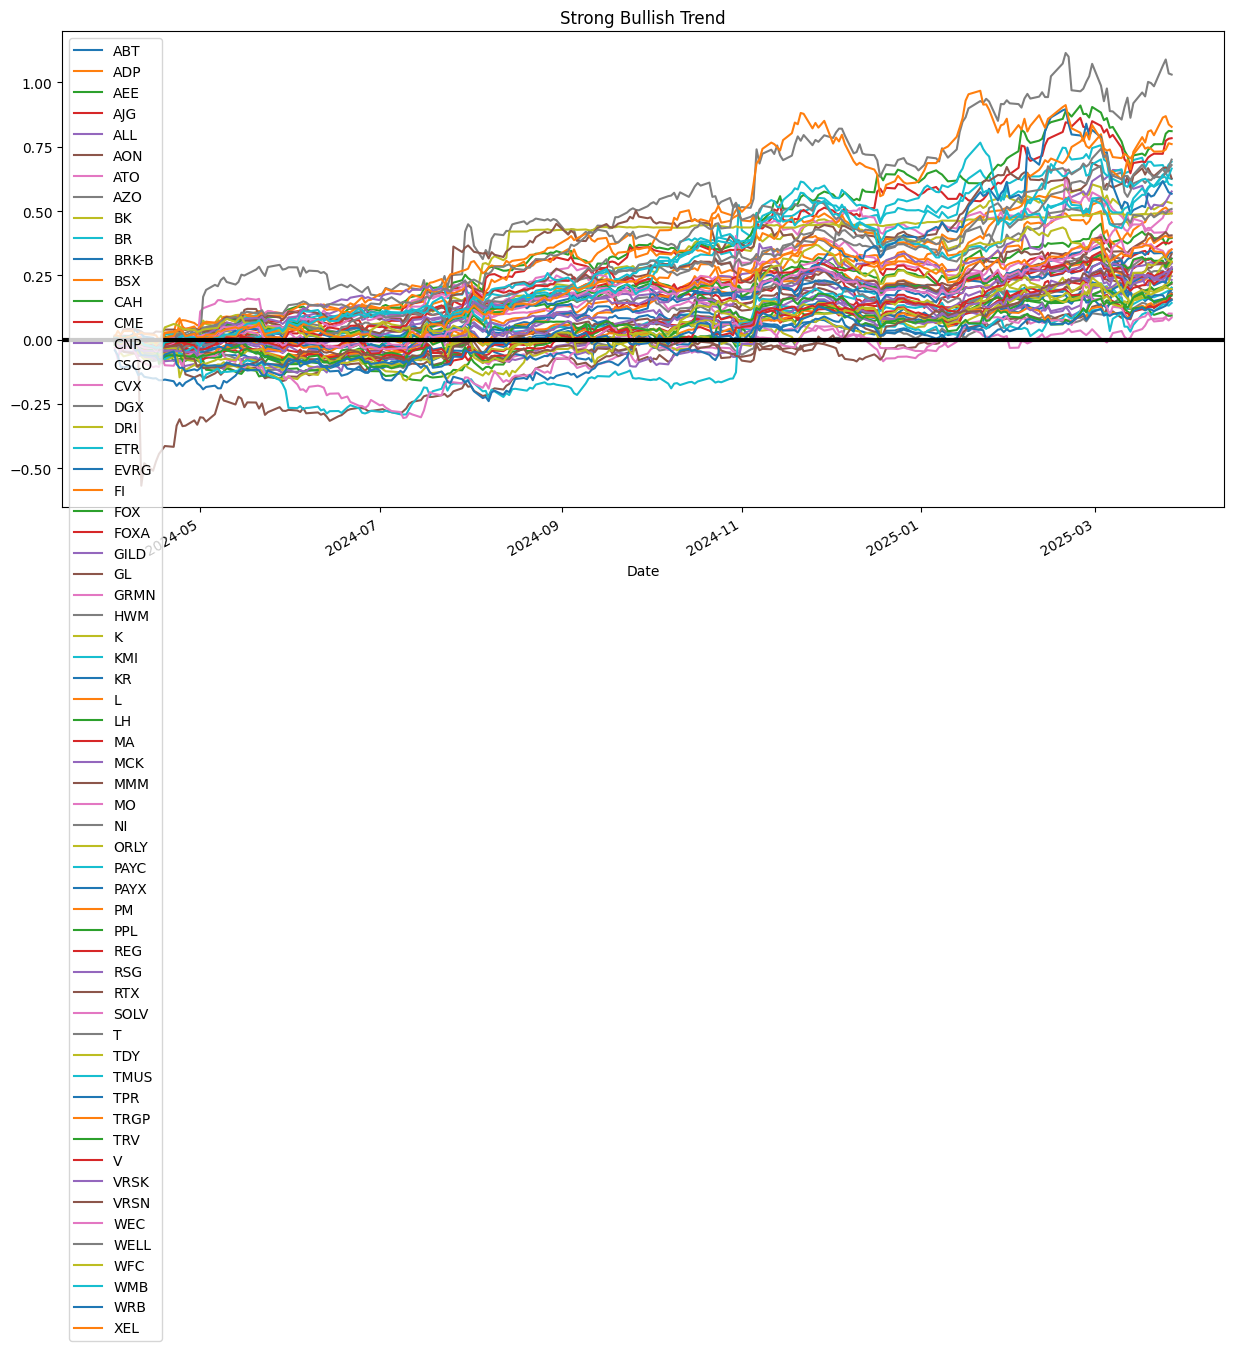

In [17]:
df_strong_bullish_trend_return = df_strong_bullish_trend_close.pct_change().dropna()
df_strong_bullish_trend_geometric_return = (1+df_strong_bullish_trend_return).cumprod()-1
display(df_strong_bullish_trend_return.tail())

#plot_compound_returns(df_strong_bullish_trend_geometric_return,title='Strong Bullish Trend') # Visualizasion with Plotly
df_strong_bullish_trend_geometric_return.plot(figsize=(15,7),title='Strong Bullish Trend')  # Visualizasion with Matplotlib
plt.axhline(y=0,linewidth=3,c='k')
plt.legend(loc='upper left') 
plt.show()

<br>

#### Bullish Trend

,DE,FTNT,JCI,RL
Date,,,,
2025-03-21,-0.009622,0.002032,-0.005051,-0.004886
2025-03-24,0.015939,0.011556,0.026226,0.053609
2025-03-25,-0.002146,0.023048,-0.002130,-0.018260
2025-03-26,0.009793,-0.010579,-0.018734,-0.012773
2025-03-27,0.009450,-0.002970,-0.001752,-0.006207


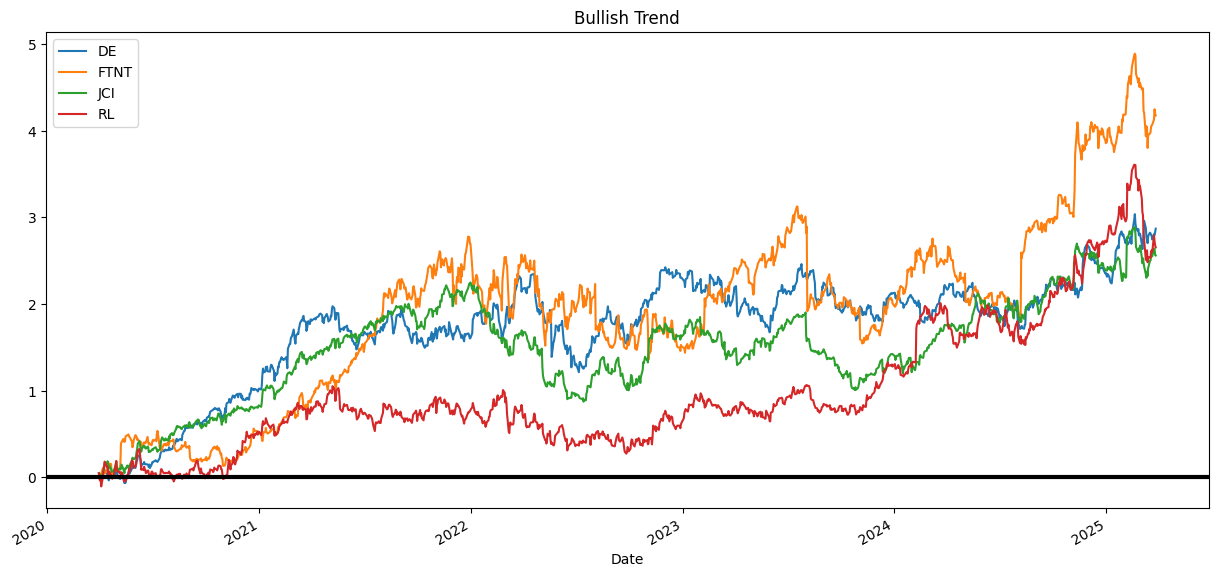

In [18]:
df_bullish_trend_return = df_bullish_trend_close.pct_change().dropna()
df_bullish_trend_geometric_return = (1+df_bullish_trend_return).cumprod()-1
display(df_bullish_trend_return.tail())

#plot_compound_returns(df_bullish_trend_geometric_return,title='Bullish Trend') # Visualizasion with Plotly 
df_bullish_trend_geometric_return.plot(figsize=(15,7), title='Bullish Trend')  # Visualizasion with Matplotlib 
plt.axhline(y=0,linewidth=3,c='k')
plt.legend(loc='upper left') 
plt.show()

<br>

#### Up Trend

,BKR,C,CTVA,FFIV,IBM,META,NFLX,NRG,NWS,SCHW
Date,,,,,,,,,,
2025-03-21,-0.012978,0.002228,-0.001779,-0.000298,0.002260,0.017491,0.009939,0.010237,-0.009018,-0.002291
2025-03-24,0.011109,0.028619,0.005671,0.022019,0.018781,0.037904,0.012184,0.021856,-0.000650,0.020028
2025-03-25,0.013005,0.005808,-0.003544,0.002698,0.005836,0.012055,0.026019,-0.005736,0.004228,0.009880
2025-03-26,-0.025675,-0.016517,0.013743,-0.008035,0.001761,-0.024477,-0.026703,-0.047912,-0.003562,-0.007554
2025-03-27,0.002499,-0.008670,0.004785,-0.014551,-0.008813,0.003977,0.017627,0.001124,-0.007150,0.003369


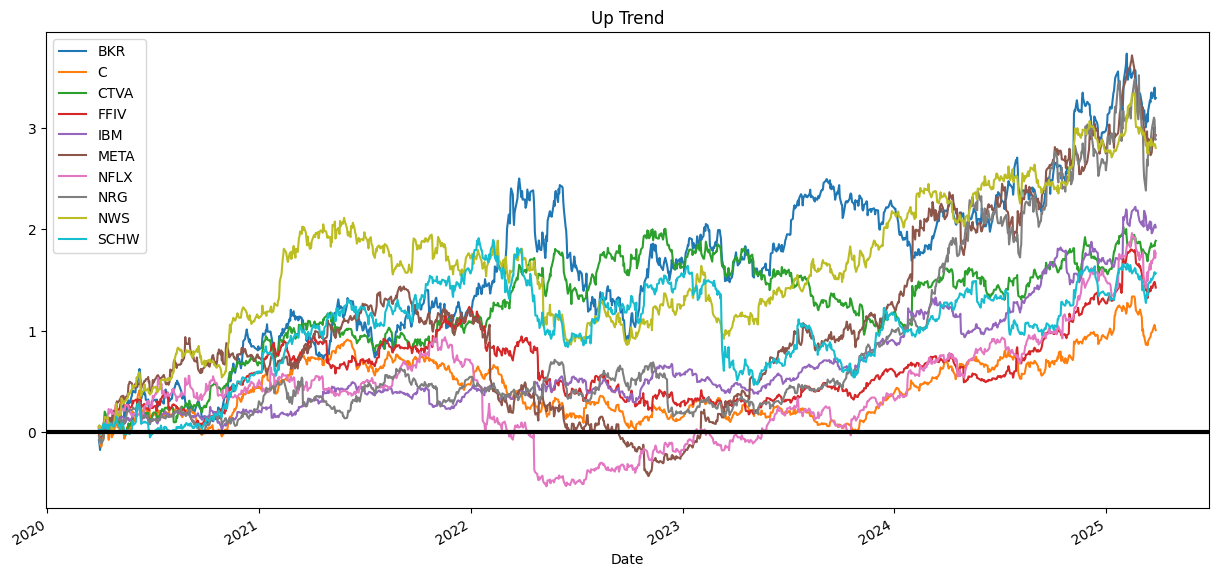

In [19]:
df_up_trend_return = df_up_trend_close.pct_change().dropna()
df_up_trend_geometric_return = (1+df_up_trend_return).cumprod()-1
display(df_up_trend_return.tail())

#plot_compound_returns(df_up_trend_geometric_return,title='Up Trend') # Visualizasion with Plotly 
df_up_trend_geometric_return.plot(figsize=(15,7),title='Up Trend')  # Visualizasion with Matplotlib
plt.axhline(y=0,linewidth=3,c='k')
plt.legend(loc='upper left') 
plt.show()

<br>

#### Consolidated Uptrend

,AIZ,CTRA,EBAY,EQT,PODD,TRMB
Date,,,,,,
2025-03-21,-0.024570,-0.009997,-0.008441,-0.015820,0.011040,-0.001981
2025-03-24,0.012570,0.022284,0.011554,0.021180,0.021318,0.021690
2025-03-25,0.006637,-0.001703,-0.003607,0.004630,-0.004853,-0.022062
2025-03-26,0.007020,-0.015012,-0.010860,-0.024516,-0.028712,-0.021850
2025-03-27,0.000942,-0.003291,0.024474,-0.014739,0.008796,-0.010444


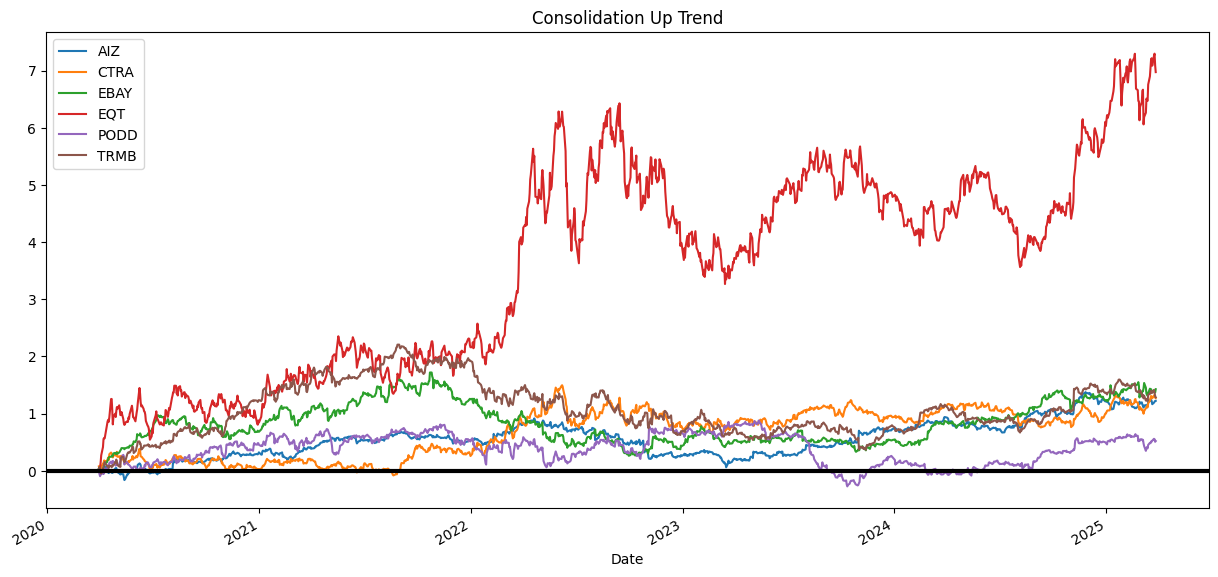

In [20]:
df_consolidated_uptrend_return = df_consolidated_uptrend_close.pct_change().dropna()
df_consolidated_uptrend_geometric_return = (1+df_consolidated_uptrend_return).cumprod()-1
display(df_consolidated_uptrend_return.tail())

#plot_compound_returns(df_consolidated_uptrend_geometric_return,title='Consolidated Uptrend') # Visualizasion with Plotly
df_consolidated_uptrend_geometric_return.plot(figsize=(15,7),title='Consolidation Up Trend') # Visualizasion with Matplotlib
plt.axhline(y=0,linewidth=3,c='k')
plt.legend(loc='upper left') 
plt.show()